<div style="width: 100%; clear: both;">
  <div style="float: left; width: 30%;">
    <img src="https://campusonline.uhemisferios.edu.ec/pluginfile.php/1/theme_mb2nl/logo/1718903214/UHE%20logo%2Bslogan.png" align="left" width="280" height="120">
  </div>
  <div style="float: right; width: 70%;">
    <p style="margin: 0; padding-top: 32px; text-align:right; color:#003366; font-size:16px"><u>Procesamiento del lenguaje</u></p>
    <p style="margin: 0; text-align:right; color:#999999; font-size:17px">Maestría en Inteligencia Artificial Aplicada</p>
  </div>
</div>

# Caso práctico 2: Representación de texto

**Calificación:** 25% de la nota global.

El presente caso práctico tiene como objetivo reforzar sus habilidades para aplicar métodos de representación de textos. A continuación, se describe la actividad que deberá realizar para cumplir el objetivo planteado.

1. Elegir un dataset de opiniones o reviews: cargar el dataset y explorar su estructura y contenido.
2. Aplicar las técnicas más apropiadas de pre-procesamiento de textos.
3. Elegir al menos dos modelos de representación vectorial y aplicarlo al dataset elegido. Se recomienda usar TF-IDF y algún otro como LDA, Word2Vec o Sentence Transformers para encontrar palabras destacadas de los mensajes (positivos y negativos) u opiniones similares. Se puede usar recursos gráficos para resaltar algunos resultados.
4. Conclusiones: Responder preguntas como ¿Para qué fue útil Word2Vec o LDA, qué nos permitió descubrir en los mensajes? ¿Se encontró algún patrón en los mensajes analizados? etc.

**Estudiante:**
- Danny Díaz

**Entregables:**
- Notebook en formato HTML (si el trabajo fue elaborado en grupo, incluir los nombres de los integrantes) en la tarea


In [26]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

<div style="background-color: #FFFF99; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<b>Etapa 1:</b> Carga, descripción del dataset elegido y comprensión de su contenido y estructura
</div>

In [ ]:
random.seed(42)
data = pd.read_csv('./data/AmazonReviews.csv').sample(20000)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
395591,395592,B002N7DSP2,A230PX1OK8INV4,S. Llewellyn,3,3,5,1155513600,The best gluten-free cookies I have ever had,I feel like have tried every gluten-free baked...
225208,225209,B004UAYXJK,A3OAFJU0QSRXP1,Daisy,0,0,5,1333929600,Excellent,The Chai Latte is excellent! So happy this is...
123396,123397,B0044BT06G,A8PP8NPRJSAKO,Brazilian Jazzaholic!,1,2,3,1332892800,"Nice flavor, but might be too thick/chunky for...",My baby girl absolutely adores Sprout stage 1 ...
411068,411069,B0039E1RHY,AIXUZAA8JQQDI,Candinse,0,0,5,1341273600,Japanese crackers,"Oh my these were so GOOD. Delicate,slightly fr..."
449429,449430,B000LKZK36,A3CMJKVO4K57GR,Desert Love,1,2,1,1200096000,Mis-boxed Item,"I COULD rate this item but ""Mild"" wasn't what ..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 395591 to 191987
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      20000 non-null  int64 
 1   ProductId               20000 non-null  object
 2   UserId                  20000 non-null  object
 3   ProfileName             19999 non-null  object
 4   HelpfulnessNumerator    20000 non-null  int64 
 5   HelpfulnessDenominator  20000 non-null  int64 
 6   Score                   20000 non-null  int64 
 7   Time                    20000 non-null  int64 
 8   Summary                 20000 non-null  object
 9   Text                    20000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [7]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,20000.000000,20000.00000,20000.000000,20000.000000,2.000000e+04
mean,284688.451050,1.66925,2.163250,4.176100,1.296843e+09
std,164101.316965,7.18553,7.787871,1.313193,4.784030e+07
min,3.000000,0.00000,0.000000,1.000000,9.657792e+08
25%,141916.000000,0.00000,0.000000,4.000000,1.272910e+09
50%,284584.500000,0.00000,1.000000,5.000000,1.311725e+09
75%,425875.250000,2.00000,2.000000,5.000000,1.333066e+09
max,568412.000000,559.00000,562.000000,5.000000,1.351210e+09


<div style="background-color: #FFFF99; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<b>Etapa 2: Pre-procesamiento de datos</b
</div>

Explorar más a fondo el contenido de los mensajes para descubrir qué problemas de los datos se detectaron y aplicar las técnicas de pre-procesamiento más adecuados.

In [10]:
# Filtrar reviews neutras (Score 3)
data = data[data['Score'] != 3]

# Crear columna de Sentimiento
data['Sentimiento'] = data['Score'].apply(lambda x: 1 if x > 3 else -1)

# Funciones de preprocesamiento
def limpiar_texto(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = text.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    return text

# Aplicar preprocesamiento
data['Text'] = data['Text'].apply(limpiar_texto)

# Tokenización y eliminación de stopwords
# stop_words = set(stopwords.words('english'))
# data['Text'] = data['Text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

data.sample(20)['Text'].values

array(['what can i say about this flour that wont make it look like i was paid to say it  i have been using this flour since i was diagnosed with celiac disease six years ago i have worked as a gluten free lifestyle coach for gf diagnosed people for years helping them to adjust to the diet and pamelas flour is one of the first things i steer them to  it is a great allaround gluten free flour  it is not too light like rice flour and not too heavy like a bean flour  it does substitute well in all of my recipes  its baking outcome is very desireable  i have never had trouble with it in fact many times the comments i get on my baked goods from my nongf friends is that they cant tell its gluten freenow to  be fair i need to mention that it does have dairy and nuts in it  this is a problem for dairy and nut allergy persons and children  this is the only drawback i see in this product  unfortunately i have not found something that i like as well to substitute for it',
       'i wasnt expectin

In [18]:
contraction_patterns = [
    (r"won't", 'will not'), (r"can't", 'cannot'), (r"i'm", 'i am'), (r"ain't", 'is not'), (r"(\w+)'ll", r'\g<1> will'),
    (r"(\w+)n't", r'\g<1> not'), (r"(\w+)'ve", r'\g<1> have'), (r"(\w+)'s", r'\g<1> is'), (r"(\w+)'re", r'\g<1> are'),
    (r"(\w+)'d", r'\g<1> would'), (r"&", 'and'), (r"dammit", 'damn it'), (r"dont", 'do not'), (r"wont", 'will not')
]

patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]

def replace_contractions(text):
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in word_tokenize(text))

data['clean_text'] = data['Text'].apply(replace_contractions).apply(lemmatize_text)

stop_words = set(stopwords.words('english'))
data['clean_text_no_stopwords'] = data['Text'].apply(replace_contractions).apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words)).apply(lemmatize_text)

data[['clean_text', 'clean_text_no_stopwords', 'Sentimiento']].head(5)

,clean_text,clean_text_no_stopwords,Sentimiento
395591,i feel like have tried every glutenfree baked ...,feel like tried every glutenfree baked good si...,1
225208,the chai latte is excellent so happy this is a...,chai latte excellent happy available keurig co...,1
411068,oh my these were so good delicateslightly frie...,oh good delicateslightly fried flavor texture ...,1
449429,i could rate this item but mild wasnt what i r...,could rate item mild wasnt received sealed box...,-1
223676,i wa intrgued with the punch line satisfy your...,intrgued punch line satisfy inner chocovore he...,1


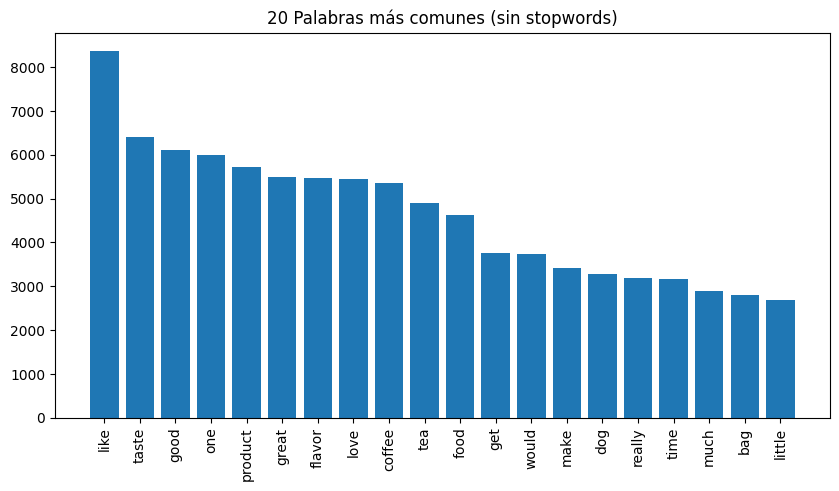

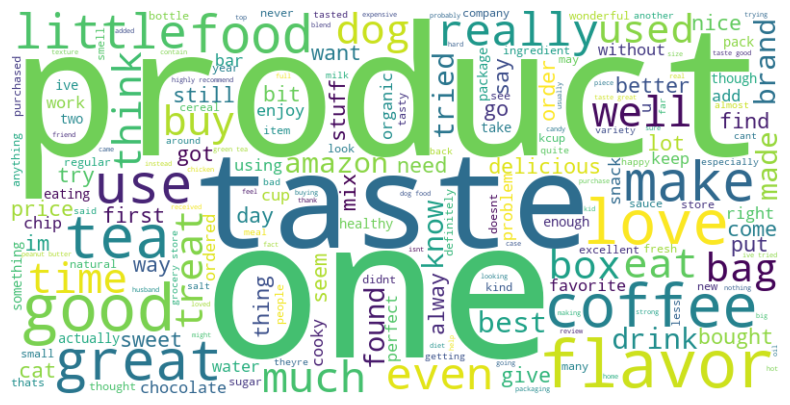

In [19]:
#  Visualización
all_words = ' '.join(data['clean_text_no_stopwords']).split()
word_counts = Counter(all_words)
most_common = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])

# Graficar las palabras más comunes
plt.figure(figsize=(10, 5))
plt.bar(most_common['word'], most_common['count'])
plt.xticks(rotation=90)
plt.title('20 Palabras más comunes (sin stopwords)')
plt.show()

def viz_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

stream = ' '.join(data['clean_text_no_stopwords'].to_list())
viz_wordcloud(stream)

In [ ]:
# Primero en el word cloud salio 'WA' con muchas repeticiones, pero lo arreglé cambiando el orden de preprocesamiento con stop words
data[data['clean_text'].str.contains('wa')][['clean_text', 'clean_text_no_stopwords', 'Sentimiento']].values[:5]

array([['the chai latte is excellent so happy this is available for the keurig i will continue to purchase this product the service wa very quick a well which wa terrific',
        'chai latte excellent happy available keurig continue purchase product service quick well terrific',
        1],
       ['oh my these were so good delicateslightly fried flavor and texture with nori and wasabi on the reverse hotspicy and just too good worth the cost and shipping',
        'oh good delicateslightly fried flavor texture nori wasabi reverse hotspicy good worth cost shipping',
        1],
       ['i could rate this item but mild wasnt what i received the sealed box that said mild on the outside actually contained wild packet what a disappointment i wa able to sell the item to a friend who liked it order with caution',
        'could rate item mild wasnt received sealed box said mild outside actually contained wild packet disappointment able sell item friend liked order caution',
        -1],
   

<div style="background-color: #FFFF99; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<b> Etapa 3: Representación vectorial de tokens o sentencias </b>
</div>

Aplicar TF-IDF y al menos otro modelo más, analizar los hallazgos que se vayan descubriendo.



In [38]:
# Función para calcular matriz de similitud de coseno
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    return np.round(similarity_matrix, 4)

# Visualizar la matriz de similitud con seaborn
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    plt.show()

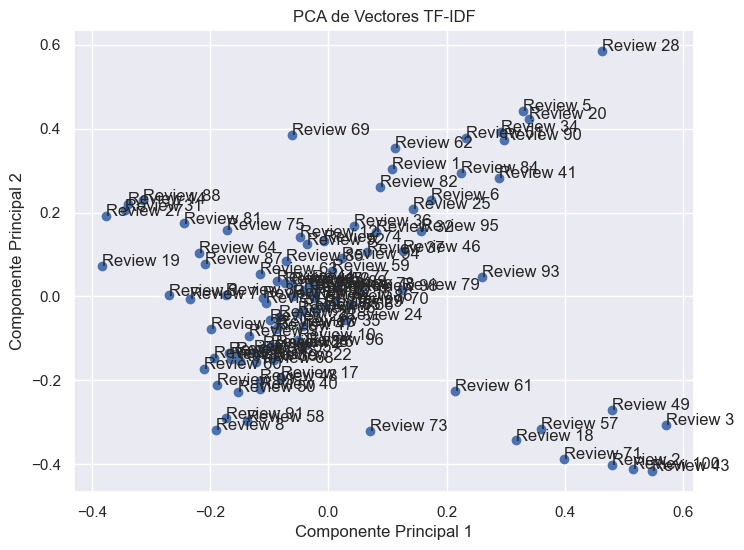

In [39]:
sample_reviews = data['clean_text_no_stopwords'].sample(100, random_state=42).tolist()

# Aplicación de TF-IDF y Sentence Transformers para representación vectorial
tfidf = TfidfVectorizer(max_features=100)
tfidf_vectors = tfidf.fit_transform(sample_reviews).toarray()
labels = [f"Review {i+1}" for i in range(len(sample_reviews))]

# Calcular similitud con TF-IDF
tfidf_similarity = cosine_similarity(tfidf_vectors)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_vectors)

# Visualización de los vectores TF-IDF en 2D con PCA
plt.figure(figsize=(8, 6))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1])

for i, review in enumerate(labels):
    plt.annotate(review, (tfidf_pca[i, 0], tfidf_pca[i, 1]))

plt.title("PCA de Vectores TF-IDF")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

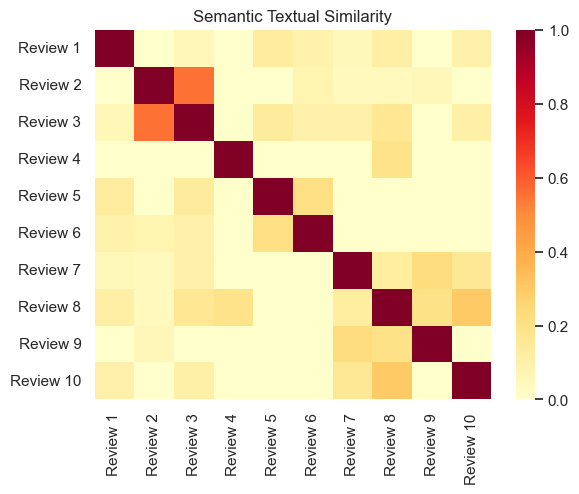

In [40]:
# TF-IDF plot
plot_similarity(labels[0:10], tfidf_vectors[0:10], 90)

In [41]:
offset = 1
print(sample_reviews[2 - offset]) # review 2
print(sample_reviews[3 - offset]) # review 3

buying onno behrends tea time thenafter last purchase noticed noexpiration date package contacted amazonthey sent u new one still expiration datewe contacted contacted importerand said able provide expirationdate teaswe consume lot tea buy worldthis first time came across packaged tea withno expiration date tea produced germanyso buyer aware tea might producedwho know may even antique
love tea usually fan flavored tea one new favorite taste like christmas cookie overpoweringly sweet


SENTENCE TRANSFORMER

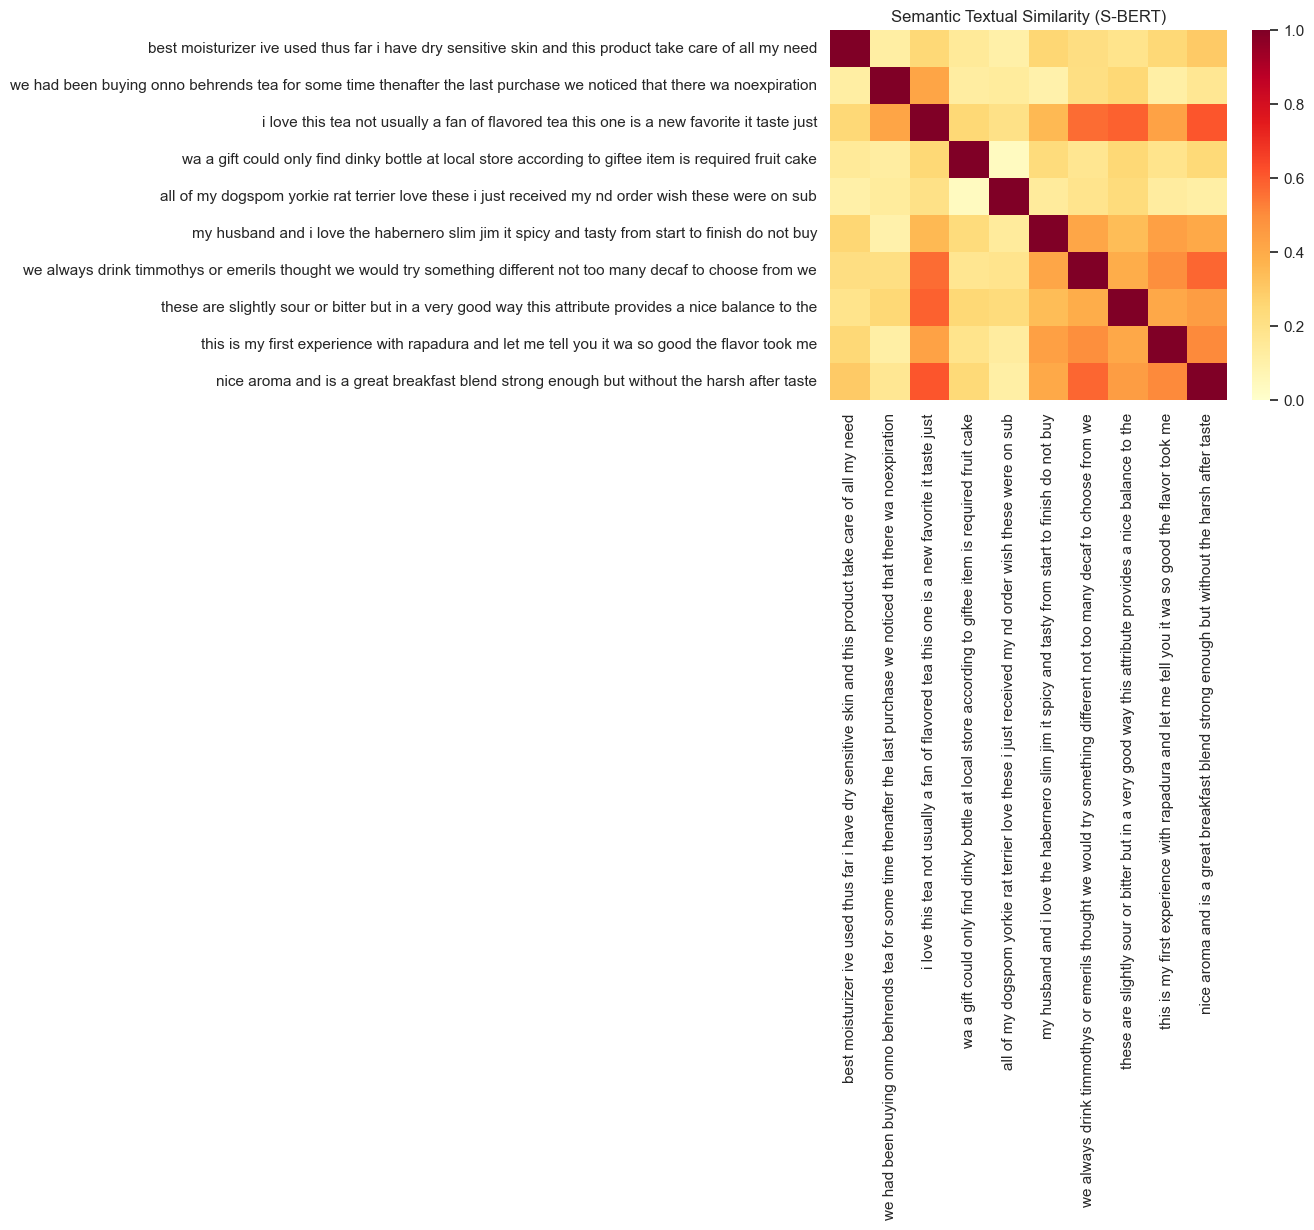

In [ ]:
sample_reviews_full_context = data['clean_text'].sample(10, random_state=42).tolist()
labels_full_context = [' '.join(review.split()[:20]) for review in sample_reviews_full_context]

model = SentenceTransformer("all-mpnet-base-v2")

# Generar embeddings para las reseñas seleccionadas
embeddings = model.encode(sample_reviews_full_context)

# Calcular matriz de similitud
sbert_similarity = cosine_similarity_matrix(embeddings)

# Etiquetas de las reseñas para el heatmap
plot_similarity(labels_full_context, embeddings, 90)

#### Positivos y negativos

In [48]:
def plot_wordcloud_freq(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

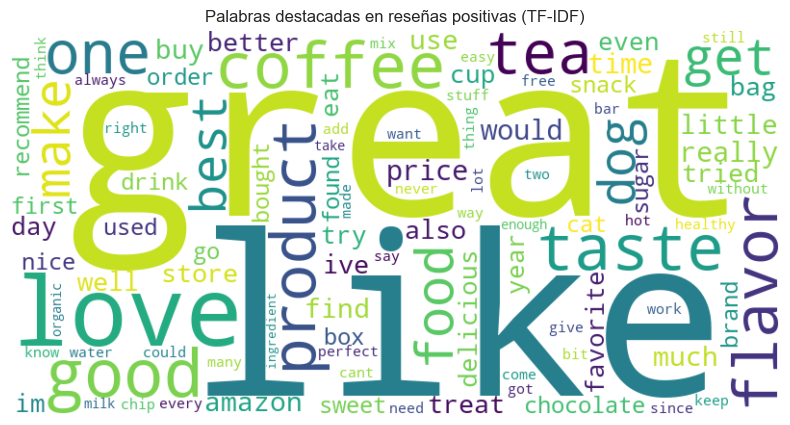

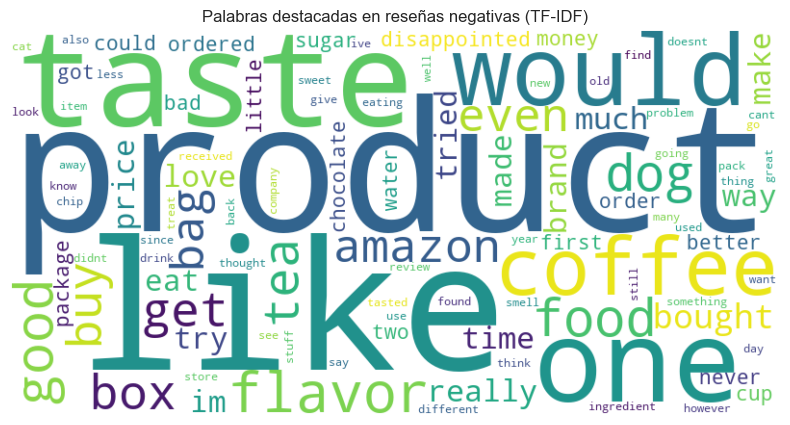

In [49]:
positives = data[data['Sentimiento'] == 1]['clean_text_no_stopwords'].tolist()
negatives = data[data['Sentimiento'] == -1]['clean_text_no_stopwords'].tolist()

tfidf = TfidfVectorizer(max_features=100)

# Palabras destacadas en reseñas positivas
tfidf_pos = tfidf.fit_transform(positives)
tfidf_pos_features = tfidf.get_feature_names_out()
tfidf_pos_scores = tfidf_pos.toarray().sum(axis=0)
top_words_pos = dict(zip(tfidf_pos_features, tfidf_pos_scores))

# Palabras destacadas en reseñas negativas
tfidf_neg = tfidf.fit_transform(negatives)
tfidf_neg_features = tfidf.get_feature_names_out()
tfidf_neg_scores = tfidf_neg.toarray().sum(axis=0)
top_words_neg = dict(zip(tfidf_neg_features, tfidf_neg_scores))

plot_wordcloud_freq(top_words_pos, "Palabras destacadas en reseñas positivas (TF-IDF)")
plot_wordcloud_freq(top_words_neg, "Palabras destacadas en reseñas negativas (TF-IDF)")

In [54]:
model = SentenceTransformer("all-mpnet-base-v2")

# Generar embeddings para mensajes positivos y negativos
pos_embeddings = model.encode(random.choices(positives, k=1000))
neg_embeddings = model.encode(random.choices(negatives, k=1000))

# Similitud promedio entre reseñas positivas
sim_matrix_pos = cosine_similarity(pos_embeddings)
avg_sim_pos = np.mean(sim_matrix_pos)

# Similitud promedio entre reseñas negativas
sim_matrix_neg = cosine_similarity(neg_embeddings)
avg_sim_neg = np.mean(sim_matrix_neg)

print(f"Similitud promedio entre reseñas positivas: {avg_sim_pos:.2f}")
print(f"Similitud promedio entre reseñas negativas: {avg_sim_neg:.2f}")

Similitud promedio entre reseñas positivas: 0.27
Similitud promedio entre reseñas negativas: 0.28


<div style="background-color: #FFFF99; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

<b> Etapa 4: Conclusiones </b>
</div>


- **TF-IDF** permite identificar las frecuencias pero se pierde el análisis de contexto. TF-IDF fue útil para identificar las palabras más relevantes en las reseñas positivas y negativas, lo que nos permitió ver términos que caracterizan cada tipo de reseña. En las reseñas positivas, las palabras destacadas suelen estar asociadas con atributos positivos de los productos, mientras que en las negativas, las palabras indican problemas o insatisfacciones.
- **Sentence Transformers** capturó mejor el contexto, revelando similitudes semánticas entre reseñas, Sentence Transformers permitió calcular la similitud entre reseñas. Observamos que las reseñas positivas tienden a ser similares entre sí, lo mismo ocurre con las negativas. La similitud promedio entre reseñas positivas y negativas revela cuán consistentes son las opiniones dentro de cada grupo de sentimiento. Aunque parece no variar mucho
- En las reseñas positivas, destacan términos como "great", "love", "good", y "favorite", reflejando satisfacción y agrado hacia el producto, especialmente en categorías como "coffee" y "tea". En las reseñas negativas, palabras como "taste", "would", "disappointed", y "money" sugieren insatisfacción, señalando problemas de calidad o expectativas no cumplidas.

!jupyter nbconvert --pdf CasoPracticoU2_DannyDiaz.ipynb